In [293]:
%pylab inline
from astropy import units
import astropy as apy
from profiles import *
from math import erf
from cosmotools import *

Populating the interactive namespace from numpy and matplotlib


In [294]:
print dens_NFW(11, 10, 0, 0, 1E12)

4481226.61354 solMass / kpc3


In [295]:
v_i = vc_NFW(11, 10, 0, 0, 1E12)
print v_i
print v_i.to(units.kpc/units.Gyr)

122.948984829 km / s
125.741422466 kpc / Gyr


In [299]:
def coulomb_log(r):
    bmax = r # position of test particle at a time t
    k = 1.42 * units.kpc # kpc
    bmin = 1.4 * k # k is the softening length if the LMC were modeled using a plummer progile . See Besla07
    L = bmax / bmin
    return np.log(L)

def sigma(c, r, M_halo):
    M_halo = M_halo * units.Msun
    Rvir = rvir2(M_halo.value, 0)  # Halo mass, Z
    vvir = np.sqrt( G * M_halo / Rvir) 
    g = log(1+c) - (c /(1+c))
    vmax = np.sqrt(0.216 * vvir**2 * c / g)
    rs = Rvir / c
    x = r / rs
    sigma = vmax * 1.4393 * x **(0.354) / (1 + 1.1756*x**0.725)
    sigma = sigma.to(units.kpc / units.Gyr)
    return sigma

sigma(11, 10 * units.kpc, 1E12)

def dynamical_friction_sis(x, y, z, vx, vy, vz, M_sat, M_halo):
    # Coordinates
    x = x * units.kpc
    y = y * units.kpc
    z = z * units.kpc
    r = np.sqrt(x**2 + y**2 + z**2)
    # Velocities
    vx = vx * units.kpc / units.Gyr
    vy = vy * units.kpc / units.Gyr
    vz = vz * units.kpc / units.Gyr
    v = np.sqrt(vx**2 + vy**2 + vz**2)
    # Density of the NFW at a given r
    rho = dens_NFW(11, x.value, y.value, z.value, M_halo) # a, r, v  ****
    # Mass of the satellite
    M_sat = M_sat * units.Msun
    # Computing the dyanmical friction
    G = constants.G
    G = G.to(units.kpc**3 / units.Msun / units.Gyr**2)
    factor = - 4 * np.pi * G**2
    Coulomb = 3# coulomb_log(r)
    s = sigma(11, r, 1E12) #       ****
    X = v / ( np.sqrt(2) * s ) 
    #print v, s, X
    # Main equation
    a_dfx = (factor * M_sat * rho * Coulomb  * (  erf(X) - 2.0*X/(np.sqrt(np.pi)) * np.exp(-X**2.0)  ) * vx) / v**3.0
    a_dfy = (factor * M_sat * rho * Coulomb  * (  erf(X) - 2.0*X/(np.sqrt(np.pi)) * np.exp(-X**2.0)  ) * vy) / v**3.0
    a_dfz = (factor * M_sat * rho * Coulomb  * (  erf(X) - 2.0*X/(np.sqrt(np.pi)) * np.exp(-X**2.0)  ) * vz) / v**3.0 
    # Transforming to the right units
    a_dfx = a_dfx.to(units.kpc / units.Gyr**2) 
    a_dfy = a_dfy.to(units.kpc / units.Gyr**2)
    a_dfz = a_dfz.to(units.kpc / units.Gyr**2)
    tt = factor * M_sat * rho * Coulomb 
    #print tt.to(units.kpc**3/units.Gyr**4)
    #print rho
    #print erf(X) - 2*X/(np.sqrt(np.pi) * np.exp(-X**2))
    #print vy/v**3.0 
    return a_dfx.value, a_dfy.value, a_dfz.value


In [303]:
print dynamical_friction_sis(10, 0, 0, 0, 153.35, 0, 1E11, 1E12)
#print dens_NFW(11, 40, 0, 0, 1E12)  

(-0.0, -9596.949916670286, -0.0)


In [300]:
def acceleration(x, y, z, vx, vy, vz):
    #M_bulge = 1E10
    #M_disk = 5.5E10
    M_halo = 1E12
    M_sat = 1E11
    #asis = a_sis(10, x, y, z, 200)
    #adisk = a_mn(6.5, 0.6, x, y, z, M_disk)
    ahalo = a_NFW(11.0, x, y, z, M_halo)
    
    ax = ahalo[0] #+ adisk[0] + ahalo[0]
    ay = ahalo[1] #+ adisk[1] + ahalo[1]
    az = ahalo[2] #+ adisk[2] + ahalo[2]
    ax = ax.to(units.kpc/units.Gyr**2)  
    ay = ay.to(units.kpc/units.Gyr**2) 
    az = az.to(units.kpc/units.Gyr**2) 
    a_dfx, a_dfy, a_dfz = dynamical_friction_sis(x, y, z, vx, vy, vz, M_sat, M_halo)
    Ax = ax.value + a_dfx 
    Ay = ay.value + a_dfy 
    Az = az.value + a_dfz 
    return Ax, Ay, Az

In [302]:
acdf = acceleration(10, 0, 0, 0, 153.35, 0)
print acdf

(-1581.0905323692525, -9596.949916670286, -0.0)


In [289]:
def leapfrog(n_points, h, x_ic, y_ic, z_ic, vx_ic, vy_ic, vz_ic):

        #n_points = 3000
        #h = 0.001
        # Creating the arrays to collect the data in each step of the integration
        # the imput units should be in Kpc and Gyrs!

        t = np.zeros(n_points)
        x = np.zeros(n_points)
        y = np.zeros(n_points)
        z = np.zeros(n_points)

        vx = np.zeros(n_points)
        vy = np.zeros(n_points)
        vz = np.zeros(n_points)


        ax = np.zeros(n_points)
        ay = np.zeros(n_points)
        az = np.zeros(n_points)

        t[0] = 0

        # This initial conditions come form MW.py, the units are Kpc and Gyr
        x[0] = x_ic
        y[0] = y_ic
        z[0] = z_ic


        vx[0] = vx_ic
        vy[0] = vy_ic
        vz[0] = vz_ic

        ax[0] = acceleration(x[0], y[0], z[0], vx[0], vy[0], vz[0])[0]
        ay[0] = acceleration(x[0], y[0], z[0], vx[0], vy[0], vz[0])[1]
        az[0] = acceleration(x[0], y[0], z[0], vx[0], vy[0], vz[0])[2]

        # one half step 

        t[1] = t[0] + h
        x[1] = x[0] + h * vx[0]
        y[1] = y[0] + h * vy[0]
        z[1] = z[0] + h * vz[0]

        vx[1] = vx[0] + h * ax[0]
        vy[1] = vy[0] + h * ay[0]
        vz[1] = vz[0] + h * az[0]

        ax[1] = acceleration(x[1],y[1], z[1], vx[1], vy[1], vz[1])[0]
        ay[1] = acceleration(x[1],y[1], z[1], vx[1], vy[1], vz[1])[1]
        az[1] = acceleration(x[1],y[1], z[1], vx[1], vy[1], vz[1])[2]

        # iterate over all the steps!

        for i in range(2,n_points):
            t[i] = t[i-1] + h

            x[i] = x[i-2] + 2 * h * vx[i-1]
            y[i] = y[i-2] + 2 * h * vy[i-1]
            z[i] = z[i-2] + 2 * h * vz[i-1]

            vx[i] = vx[i-2] + 2 * h * acceleration(x[i-1], y[i-1], z[i-1], vx[i-1], vy[i-1], vz[i-1])[0]
            vy[i] = vy[i-2] + 2 * h * acceleration(x[i-1], y[i-1], z[i-1], vx[i-1], vy[i-1], vz[i-1])[1]
            vz[i] = vz[i-2] + 2 * h * acceleration(x[i-1], y[i-1], z[i-1], vx[i-1], vy[i-1], vz[i-1])[2]
        
        return x, y, z, t, ax, ay, az 

In [ ]:
X, Y, Z, t, ax, ay, az = leapfrog(600, 0.01, 10, 0, 0, 0, 153.35, 0)

In [ ]:
figure(figsize=(7, 7))
plot(X, Y)

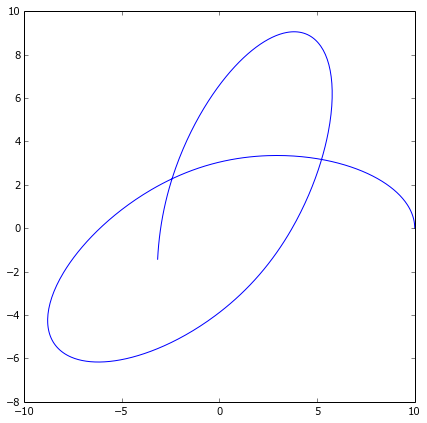

In [249]:
figure(figsize=(7, 7))

plot(X, Y)
#xlim(9.5, 10.4)
#ylim(-25, 10)

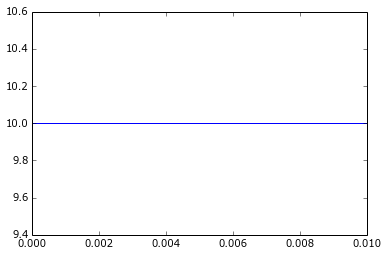

In [228]:
plot(t, np.sqrt(X**2+Y**2+Z**2))